# Ephys and behavior data format
The main purpose of this notebook is to introduce the dynamic foraging behavior and the ephys data format and how to combine them, through some simple examples.
## Behavior data introduction
- Behavior NWB introduction
- Behavior visualization
## Ephys data introduction
- Read the Ephys NWB and format introduction
- Get The number of units that passed the default qc
- Visualize the spike raster and PSTH of single units
- Cluster units based on PSTHs


In [1]:
# required packages
import os
import warnings
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from hdmf_zarr import NWBZarrIO
from pynwb import NWBHDF5IO
from aind_dynamic_foraging_basic_analysis.plot import plot_foraging_session

# Suppress specific HDMF namespace warnings
warnings.filterwarnings("ignore", category=UserWarning, module="hdmf.spec.namespace")

In [3]:
## Read the behavior NWB

# Path to one example behavior NWB file
example_behavior_nwb_file = '/root/capsule/data/behavior_nwb/753126_2024-10-11_13-14-24.nwb'

# Open the NWB file without using 'with' to keep it open
io = NWBHDF5IO(example_behavior_nwb_file, "r")
nwb_behavior_data = io.read()

# Show the layout 
nwb_behavior_data


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/root/capsule/data/behavior_nwb/753126_2024-10-11_13-14-24.nwb', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Here is a short explanation of what each of these columns mean:

**nwb_behavior_data.acquisition**
- `left_reward_delivery_time` : The reward delivery time of the left lick spout. 
- `right_reward_delivery_time` : The reward delivery time of the right lick spout. 
- `left_lick_time` : The time of the left lick.
- `right_lick_time` : The time of the right lick.

**nwb_behavior_data.intervals['trials']**

Behavior events
- `animal_response` : "The response of the animal. 0, left choice; 1, right choice; 2, no response"
- `rewarded_historyL` : "The reward history of left lick port"
- `rewarded_historyR` : "The reward history of right lick port"
- `delay_start_time` : "The delay start time"
- `goCue_start_time` : "The go cue start time"
- `reward_outcome_time` : "The reward outcome time (reward/no reward/no response) Note: This is in fact time when choice is registered.
- `start_time` : "Trial start time"
- `end_time` : "Trial end time"

Training parameters - behavior structure
- `bait_left` : "Whether the current left lickport has a bait or not"
- `bait_right` : "Whether the current right lickport has a bait or not"
- `base_reward_probability_sum` : "The summation of left and right reward probability"
- `reward_probabilityL` : "The reward probability of left lick port"
- `reward_probabilityR` : "The reward probability of right lick port"
- `reward_random_number_left` : "The random number used to determine the reward of left lick port"
- `reward_random_number_right` : "The random number used to determine the reward of right lick port"
- `left_valve_open_time` : "The left valve open time"
- `right_valve_open_time` : "The right valve open time"

Training parameters - block
- `block_beta` : "The beta of exponential distribution to generate the block length"
- `block_min` : "The minimum length allowed for each block"
- `block_max` : "The maxmum length allowed for each block"
- `min_reward_each_block` : "The minimum reward allowed for each block"

Training parameters - delay duration
- `delay_beta` : "The beta of exponential distribution to generate the delay duration(s)"
- `delay_min` : "The minimum duration(s) allowed for each delay"
- `delay_max` : "The maxmum duration(s) allowed for each delay"
- `delay_duration` : "The expected time duration between delay start and go cue start"

Training parameters - ITI duration
- `ITI_beta` : "The beta of exponential distribution to generate the ITI duration(s)"
- `ITI_min` : "The minimum duration(s) allowed for each ITI"
- `ITI_max` : "The maxmum duration(s) allowed for each ITI"
- `ITI_duration` : "The expected time duration between trial start and ITI start"

Training parameters - response duration
- `response_duration` : "The maximum time that the animal must make a choce in order to get a reward"

Training parameters - reward consumption duration
- `reward_consumption_duration` : "The duration for the animal to consume the reward"

Training parameters - reward delay
- `reward_delay` : "The delay between choice and reward delivery"

Training parameters - auto water
- `auto_waterL` : "Autowater given at Left"
- `auto_waterR` : "Autowater given at Right"

Training parameters - optogenetics
- `laser_on_trial` : "Trials with laser stimulation"
- `laser_wavelength` : "The wavelength of laser or LED"
- `laser_location` : "The target brain areas"
- `laser_1_power` : "The laser power of the laser 1(mw)"
- `laser_2_power` : "The laser power of the laser 2(mw)"
- `laser_on_probability` : "The laser on probability"
- `laser_duration` : "The laser duration"
- `laser_condition` : "The laser on is conditioned on LaserCondition"
- `laser_condition_probability` : "The laser on is conditioned on LaserCondition with a probability LaserConditionPro"
- `laser_start` : "Laser start is aligned to an event"
- `laser_start_offset` : "Laser start is aligned to an event with an offset"
- `laser_end` : "Laser end is aligned to an event"
- `laser_end_offset` : "Laser end is aligned to an event with an offset"
- `laser_protocol` : "The laser waveform"
- `laser_frequency` : "The laser waveform frequency"
- `laser_rampingdown` : "The ramping down time of the laser"
- `laser_pulse_duration` : "The pulse duration for Pulse protocol"
- `session_wide_control` : "Control the optogenetics session wide (e.g. only turn on opto in half of the session)"
- `fraction_of_session` : "Turn on/off opto in a fraction of the session (related to session_wide_control)"
- `session_start_with` : "The session start with opto on or off (related to session_wide_control)"
- `session_alternation` : "Turn on/off opto in every other session (related to session_wide_control)"
- `minimum_opto_interval` : "Minimum interval between two optogenetics trials (number of trials)"

Training parameters - auto training parameters
- `auto_train_engaged` : "Whether the auto training is engaged"
- `auto_train_curriculum_name` : "The name of the auto training curriculum"
- `auto_train_curriculum_version` : "The version of the auto training curriculum"
- `auto_train_curriculum_schema_version` : "The schema version of the auto training curriculum"
- `auto_train_stage` : "The current stage of auto training"
- `auto_train_stage_overridden` : "Whether the auto training stage is overridden"
    
Training parameters - lickspout position
- `lickspout_position_x` : "x position (um) of the lickspout position (left-right)"
- `lickspout_position_y` : "y position (um) of the lickspout position (forward-backward)"
- `lickspout_position_z` : "z position (um) of the lickspout position (up-down)"

Training parameters - reward size
- `reward_size_left` : "Left reward size (uL)"
- `reward_size_right` : "Right reward size (uL)"

(<Figure size 3000x600 with 2 Axes>, [<Axes: >, <Axes: xlabel='Trial number'>])

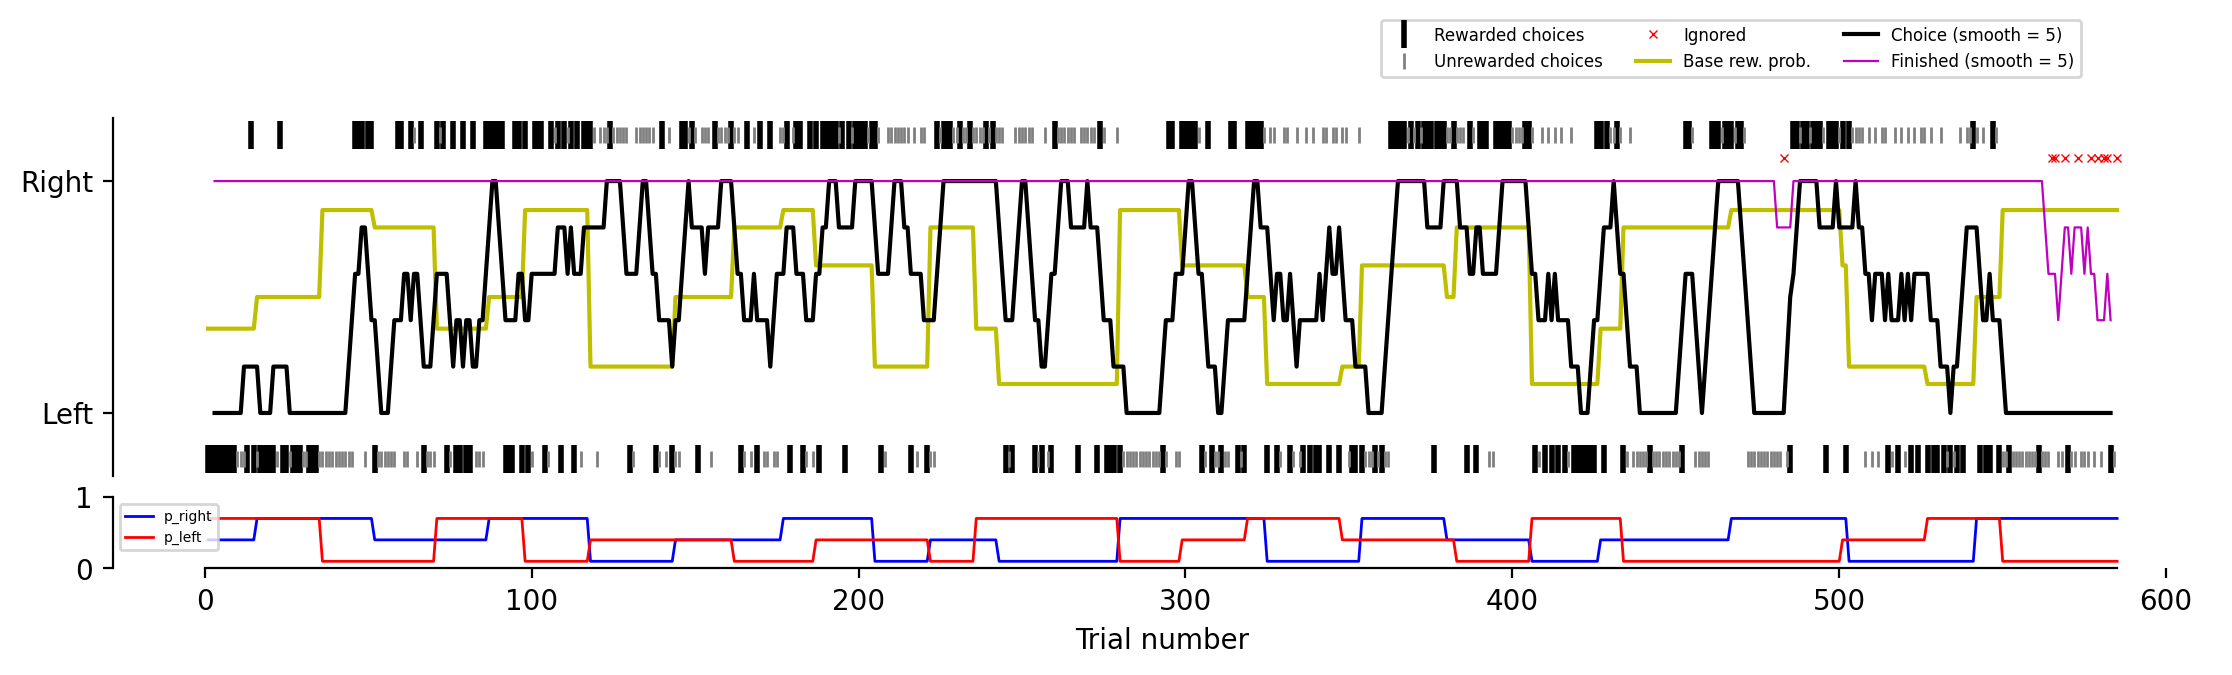

In [43]:
# plot the behavior session

trials=nwb_behavior_data.intervals['trials'][:]
choice_history = trials['animal_response'].to_numpy()
# Replace 2 with np.nan
choice_history[choice_history == 2] = np.nan

plot_foraging_session.plot_foraging_session(
    choice_history=choice_history,
    reward_history=trials['rewarded_historyL'] | trials['rewarded_historyR'],
    p_reward=np.vstack((np.array(trials['reward_probabilityL']), np.array(trials['reward_probabilityR']))),
    
)

In [39]:
## Read the ephys NWB

# One example nwb file (Please read NWB with label "experimet1", this is the NWB associated with the behavior. Other experiments are for finding the surface of the probe track.)
example_ephys_nwb_file='/root/capsule/data/ecephys_753126_2024-10-11_13-14-24_sorted_2024-11-09_19-18-21/nwb/ecephys_753126_2024-10-11_13-14-24_experiment1_recording1.nwb'

# Read the ephys nwb
io=NWBZarrIO(example_ephys_nwb_file, "r")
nwb_ephys_data = io.read()

# Show the layout
nwb_ephys_data.units

units pynwb.misc.Units at 0x139886466675568
Fields:
  colnames: ['spike_times' 'electrodes' 'waveform_mean' 'waveform_sd' 'unit_name'
 'rp_violations' 'peak_to_valley' 'amplitude_cv_range' 'estimated_z'
 'ks_unit_id' 'amplitude' 'firing_range' 'num_negative_peaks' 'spread'
 'amplitude_cutoff' 'recovery_slope' 'l_ratio' 'default_qc' 'sync_spike_8'
 'sliding_rp_violation' 'silhouette' 'decoder_probability'
 'velocity_below' 'velocity_above' 'depth' 'drift_mad'
 'isi_violations_count' 'sync_spike_2' 'drift_std' 'firing_rate'
 'presence_ratio' 'snr' 'amplitude_cv_median' 'peak_trough_ratio'
 'nn_hit_rate' 'original_cluster_id' 'amplitude_median' 'nn_miss_rate'
 'decoder_label' 'd_prime' 'isolation_distance' 'device_name'
 'estimated_y' 'sync_spike_4' 'exp_decay' 'num_positive_peaks'
 'rp_contamination' 'repolarization_slope' 'num_spikes' 'drift_ptp'
 'isi_violations_ratio' 'estimated_x' 'half_width']
  columns: (
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>,
    waveform_mean <class 'hdmf.common.table.VectorData'>,
    waveform_sd <class 'hdmf.common.table.VectorData'>,
    unit_name <class 'hdmf.common.table.VectorData'>,
    rp_violations <class 'hdmf.common.table.VectorData'>,
    peak_to_valley <class 'hdmf.common.table.VectorData'>,
    amplitude_cv_range <class 'hdmf.common.table.VectorData'>,
    estimated_z <class 'hdmf.common.table.VectorData'>,
    ks_unit_id <class 'hdmf.common.table.VectorData'>,
    amplitude <class 'hdmf.common.table.VectorData'>,
    firing_range <class 'hdmf.common.table.VectorData'>,
    num_negative_peaks <class 'hdmf.common.table.VectorData'>,
    spread <class 'hdmf.common.table.VectorData'>,
    amplitude_cutoff <class 'hdmf.common.table.VectorData'>,
    recovery_slope <class 'hdmf.common.table.VectorData'>,
    l_ratio <class 'hdmf.common.table.VectorData'>,
    default_qc <class 'hdmf.common.table.VectorData'>,
    sync_spike_8 <class 'hdmf.common.table.VectorData'>,
    sliding_rp_violation <class 'hdmf.common.table.VectorData'>,
    silhouette <class 'hdmf.common.table.VectorData'>,
    decoder_probability <class 'hdmf.common.table.VectorData'>,
    velocity_below <class 'hdmf.common.table.VectorData'>,
    velocity_above <class 'hdmf.common.table.VectorData'>,
    depth <class 'hdmf.common.table.VectorData'>,
    drift_mad <class 'hdmf.common.table.VectorData'>,
    isi_violations_count <class 'hdmf.common.table.VectorData'>,
    sync_spike_2 <class 'hdmf.common.table.VectorData'>,
    drift_std <class 'hdmf.common.table.VectorData'>,
    firing_rate <class 'hdmf.common.table.VectorData'>,
    presence_ratio <class 'hdmf.common.table.VectorData'>,
    snr <class 'hdmf.common.table.VectorData'>,
    amplitude_cv_median <class 'hdmf.common.table.VectorData'>,
    peak_trough_ratio <class 'hdmf.common.table.VectorData'>,
    nn_hit_rate <class 'hdmf.common.table.VectorData'>,
    original_cluster_id <class 'hdmf.common.table.VectorData'>,
    amplitude_median <class 'hdmf.common.table.VectorData'>,
    nn_miss_rate <class 'hdmf.common.table.VectorData'>,
    decoder_label <class 'hdmf.common.table.VectorData'>,
    d_prime <class 'hdmf.common.table.VectorData'>,
    isolation_distance <class 'hdmf.common.table.VectorData'>,
    device_name <class 'hdmf.common.table.VectorData'>,
    estimated_y <class 'hdmf.common.table.VectorData'>,
    sync_spike_4 <class 'hdmf.common.table.VectorData'>,
    exp_decay <class 'hdmf.common.table.VectorData'>,
    num_positive_peaks <class 'hdmf.common.table.VectorData'>,
    rp_contamination <class 'hdmf.common.table.VectorData'>,
    repolarization_slope <class 'hdmf.common.table.VectorData'>,
    num_spikes <class 'hdmf.common.table.VectorData'>,
    drift_ptp <class 'hdmf.common.table.VectorData'>,
    isi_violations_ratio <class 'hdmf.common.table.VectorData'

Here is a short explanation of what each of these columns mean (more details in https://spikeinterface.readthedocs.io/en/stable/modules/qualitymetrics.html):

- `spike_times` - spike times (in seconds) for the entire session
- `electrodes` - electrode indices used for mean waveform
- `waveform_mean` - mean spike waveform across all electrodes
- `waveform_sd` - standard deviation of the spike waveform across all electrodes
- `unit_name` - universally unique identifier for this unit
- `default_qc` - `True` if this unit passes default quality control criteria, `False` otherwise
- **presence_ratio** - fraction of the session for which this unit was present (**default threshold = 0.8.** The presence ratio measures the fraction of time bins (often divided into equal segments) during which a neuron fires at least one spike. It reflects whether the neuron's activity is evenly distributed throughout the recording or concentrated in a short period.)
- `num_spikes` - total number of spikes detected
- `snr` - signal-to-noise ratio of this unit's waveform (relative to the peak channel)
- **isi_violations_ratio** - metric that quantifies spike contamination (**default threshold = 0.5.**  Neurons have a refractory period after a spiking event during which they cannot fire again. Inter-spike-interval (ISI) violations refers to the rate of refractory period violations. **Low value**: Indicates a well-separated cluster, likely representing a single neuron.
**High value**: Suggests overlap with other clusters, raising the possibility of misclassified spikes.)
- `firing_rate` - average firing rate of the unit throughout the session
- `isolation_distance` - distance to nearest cluster in Mahalanobis space (higher is better)
- `l_ratio` - related to isolation distance; quantifies the probability of cluster membership for each spike
- `device_name` - name of the probe that detected this unit
- **amplitude_cutoff** - estimated fraction of missed spikes (**default threshold = 0.1.** It measures the fraction of a neuron’s spikes that were missed due to thresholding. It estimates the likelihood that the neuron's smaller spikes were not detected because they fall below a detection threshold. **Low amplitude cutoff**: Indicates a good detection of spikes; very few spikes were missed.
**High amplitude cutoff**: Suggests a significant number of spikes may have been missed, likely due to smaller amplitude spikes falling below the detection threshold.
)
- `peak_trough_ratio` - ratio of the max (peak) to the min (trough) amplitudes (based on 1D waveform)
- `repolarization_slope` - slope of return to baseline after trough (based on 1D waveform)
- `amplitude` - peak-to-trough distance (based on 1D waveform)
- `d_prime` - classification accuracy based on LDA (higher is better)
- `recovery_slope` - slope of return to baseline after peak (based on 1D waveform)
- `half_width` - width of the waveform at half the trough amplitude (based on 1D waveform)
- `ks_unit_id` - unit ID assigned by Kilosort
- `sliding_rp_violation` - refractory violatoin that considers unit firing rate
- `drift_std`,`drift_mad`, `drift_ptp`: the standard deviation, mean absolute deviation, and peak-to-peak of the estimated location of unit over the recording


In [40]:
## Get units that pass the default qc and are not labeled as noise
units = nwb_ephys_data.units[:]
units_passing_qc = units[((units.default_qc == "True") | (units.default_qc == True)) & (units.decoder_label != 'noise')]
print(f"Number of units passing the default QC: {len(units_passing_qc)}")


Number of units passing the default QC: 383


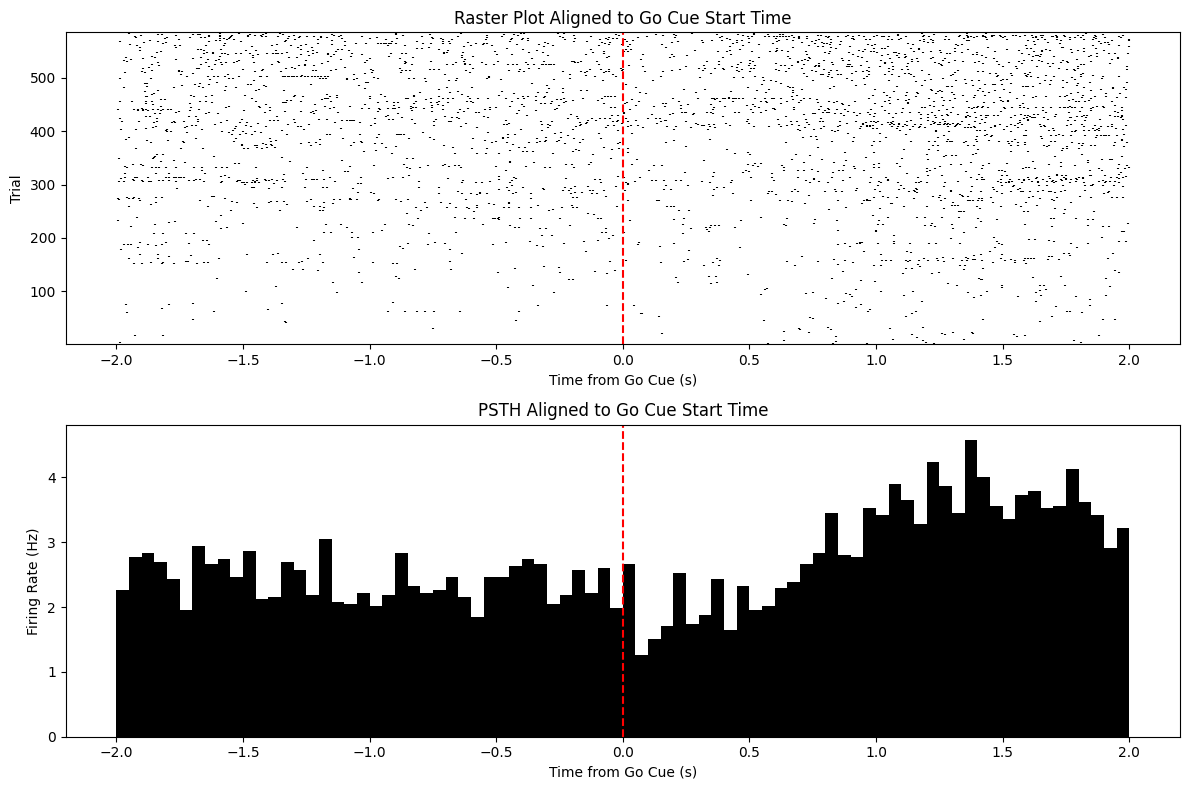

In [41]:
## plot the spike raster and PSTH of single unit

#unit index
unit_index=10

# Extract go cue start times for each trial
go_cue_times = nwb_behavior_data.trials.goCue_start_time[:]

# Extract spike times for the specified unit
unit_spike_times = units_passing_qc.spike_times.iloc[unit_index]

# Define the time window around the go cue (from -1s to +2s)
time_window = [-2, 2]  # in seconds

# Number of trials
num_trials = len(go_cue_times)

# Initialize lists to collect aligned spike times
spikes_aligned = []
all_spikes_aligned = []

# Align spike times to the go cue for each trial
for trial_idx, go_cue_time in enumerate(go_cue_times):
    # Define the start and end time of the window for this trial
    start_time = go_cue_time + time_window[0]
    end_time = go_cue_time + time_window[1]
    # Get spikes within the window
    spikes_in_window = unit_spike_times[(unit_spike_times >= start_time) & (unit_spike_times <= end_time)]
    # Align spikes to the go cue
    spikes_aligned_trial = spikes_in_window - go_cue_time
    # Store the aligned spikes and trial index
    spikes_aligned.append((trial_idx, spikes_aligned_trial))
    # Collect all aligned spikes for PSTH
    all_spikes_aligned.extend(spikes_aligned_trial)

# Create a figure with two subplots: raster plot and PSTH
plt.figure(figsize=(12, 8))

# Plot the raster plot
ax1 = plt.subplot(2, 1, 1)
for trial_idx, spikes_in_trial in spikes_aligned:
    plt.vlines(spikes_in_trial, trial_idx + 0.5, trial_idx + 1.5, color='black')
plt.axvline(0, color='red', linestyle='--')  # Go cue time marker
plt.xlabel('Time from Go Cue (s)')
plt.ylabel('Trial')
plt.title('Raster Plot Aligned to Go Cue Start Time')
plt.ylim(0.5, num_trials + 0.5)


# Define bin size and bins for PSTH
bin_size = 0.05  # 50 ms bins
bins = np.arange(time_window[0], time_window[1] + bin_size, bin_size)
hist_counts, _ = np.histogram(all_spikes_aligned, bins=bins)

# Convert counts to firing rate (spikes per second)
hist_rates = hist_counts / num_trials / bin_size

# Plot the PSTH
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.bar(bins[:-1], hist_rates, width=bin_size, align='edge', color='black')
plt.axvline(0, color='red', linestyle='--')  # Go cue time marker
plt.xlabel('Time from Go Cue (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('PSTH Aligned to Go Cue Start Time')

plt.tight_layout()
plt.show()


/tmp/ipykernel_25281/725953119.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


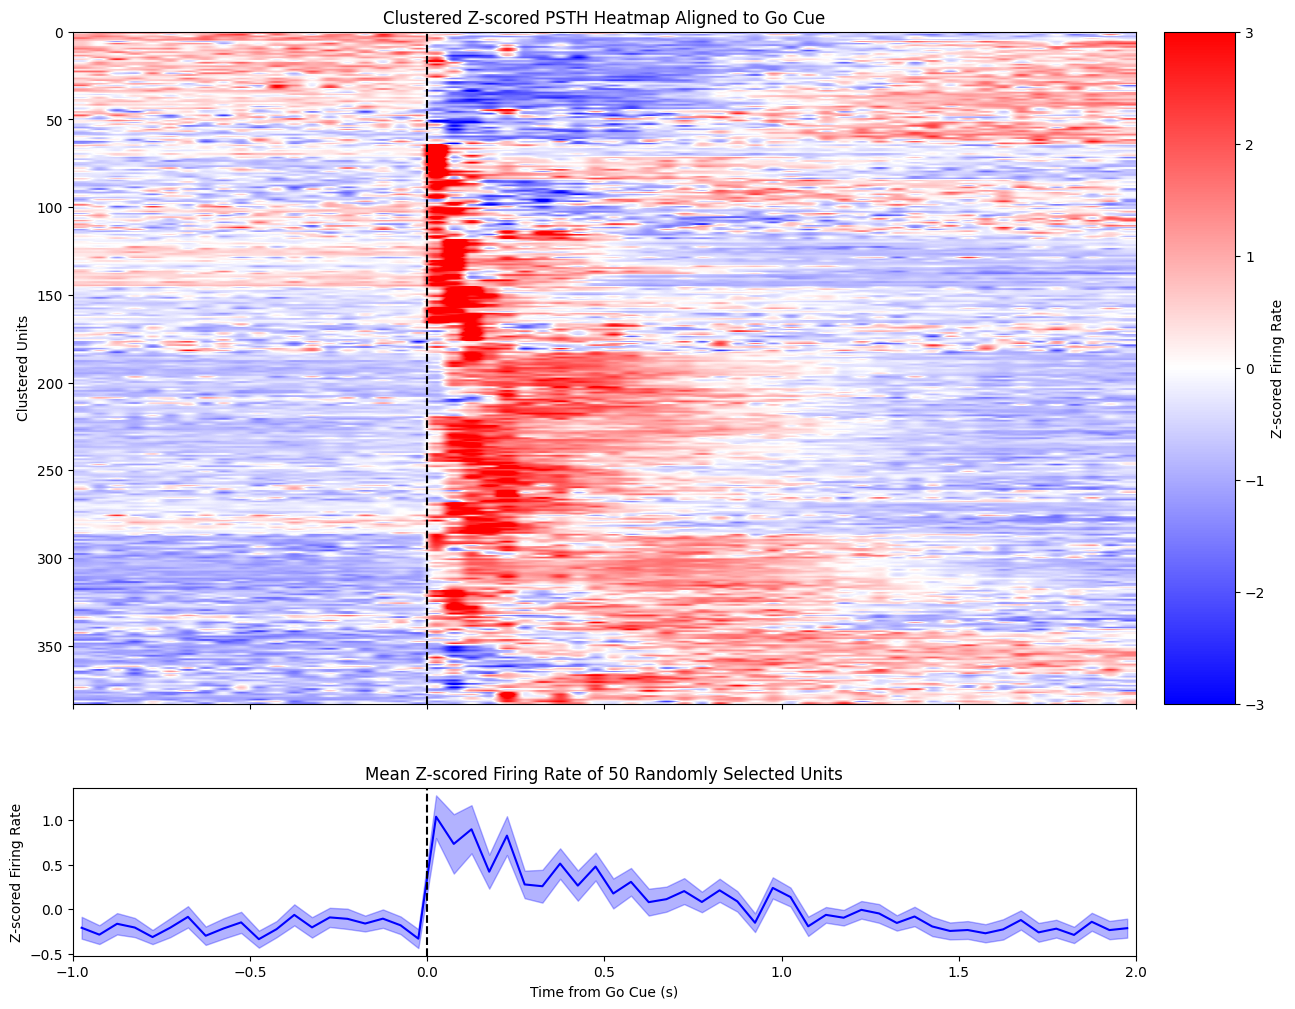

In [42]:
## Cluster units based on PSTHs and perform visualization

# Ensure reproducibility by setting random seeds
random.seed(42)
np.random.seed(42)  # For numpy-related randomness

# Extract go cue start times for each trial
go_cue_times = nwb_behavior_data.trials.goCue_start_time[:]

# Total number of units available
num_units = len(units_passing_qc)

# Define the time window around the go cue (from -1s to +2s)
time_window = [-1, 2]  # in seconds

# Define bin size and bins for PSTH
bin_size = 0.05  # 50 ms bins
bins = np.arange(time_window[0], time_window[1] + bin_size, bin_size)
bin_centers = bins[:-1] + bin_size / 2

# Initialize an array to hold the PSTH for all units
psth_all_units = np.zeros((num_units, len(bins) - 1))

# Loop over each unit to compute the PSTH
for unit_idx in range(num_units):
    # Extract spike times for the current unit
    unit_spike_times = units_passing_qc.spike_times.iloc[unit_idx]

    # Initialize a list to collect all aligned spikes
    all_spikes_aligned = []

    # Align spike times to the go cue for each trial
    for go_cue_time in go_cue_times:
        # Define the start and end time of the window for this trial
        start_time = go_cue_time + time_window[0]
        end_time = go_cue_time + time_window[1]
        # Get spikes within the window
        spikes_in_window = unit_spike_times[(unit_spike_times >= start_time) & (unit_spike_times <= end_time)]
        # Align spikes to the go cue
        spikes_aligned_trial = spikes_in_window - go_cue_time
        # Collect all aligned spikes
        all_spikes_aligned.extend(spikes_aligned_trial)

    # Compute histogram for the current unit
    hist_counts, _ = np.histogram(all_spikes_aligned, bins=bins)
    # Convert counts to firing rate (spikes per second)
    hist_rates = hist_counts / len(go_cue_times) / bin_size
    # Store the PSTH for the current unit
    psth_all_units[unit_idx, :] = hist_rates

# Z-score the PSTH for each unit across time bins
mean_psth = np.mean(psth_all_units, axis=1, keepdims=True)
std_psth = np.std(psth_all_units, axis=1, ddof=1, keepdims=True)
# Avoid division by zero by setting zero std to a small number
std_psth[std_psth == 0] = 1e-10
z_psth_all_units = (psth_all_units - mean_psth) / std_psth

# Hierarchical clustering of units based on their z-scored PSTH
# Compute the linkage matrix
linkage_matrix = linkage(z_psth_all_units, method='ward')

# Get the order of units from the hierarchical clustering dendrogram
dendro = dendrogram(linkage_matrix, no_plot=True)
cluster_order = dendro['leaves']

# Reorder the z-scored PSTH data according to the clustering
z_psth_all_units_clustered = z_psth_all_units[cluster_order, :]

# Randomly select 50 units for mean z-scored firing rate (after clustering)
random_unit_indices = random.sample(list(cluster_order), 50)

# Get the z-scored PSTH data for the selected units
z_psth_selected_units = z_psth_all_units[random_unit_indices, :]

# Compute the mean z-scored firing rate across the selected units
mean_z_firing_rate = np.mean(z_psth_selected_units, axis=0)
# Compute the standard error of the mean (SEM)
sem_z_firing_rate = np.std(z_psth_selected_units, axis=0, ddof=1) / np.sqrt(len(random_unit_indices))

# Create a GridSpec with an extra column for the colorbar
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[15, 1], height_ratios=[4, 1], wspace=0.05)

# Plot the clustered z-scored PSTH heatmap using imshow
ax0 = plt.subplot(gs[0, 0])
im = ax0.imshow(z_psth_all_units_clustered, aspect='auto',
                extent=[time_window[0], time_window[1], num_units, 0],
                cmap='bwr', vmin=-3, vmax=3)
ax0.axvline(0, color='black', linestyle='--')
ax0.set_ylabel('Clustered Units')
ax0.set_title('Clustered Z-scored PSTH Heatmap Aligned to Go Cue')
ax0.set_xlim(time_window[0], time_window[1])
ax0.tick_params(labelbottom=False)

# Plot the colorbar in a separate panel
cax = plt.subplot(gs[0, 1])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Z-scored Firing Rate')

# Plot the mean z-scored firing rate with error bars
ax1 = plt.subplot(gs[1, 0], sharex=ax0)
ax1.plot(bin_centers, mean_z_firing_rate, color='blue')
ax1.fill_between(bin_centers,
                 mean_z_firing_rate - sem_z_firing_rate,
                 mean_z_firing_rate + sem_z_firing_rate,
                 color='blue', alpha=0.3)
ax1.axvline(0, color='black', linestyle='--')
ax1.set_xlabel('Time from Go Cue (s)')
ax1.set_ylabel('Z-scored Firing Rate')
ax1.set_title('Mean Z-scored Firing Rate of 50 Randomly Selected Units')

plt.tight_layout()
plt.show()


In [ ]:
## LFP data is stored in the dataset before the spike sorting

example_lfp_data_path="/data/ecephys_753126_2024-10-11_13-14-24/ecephys/ecephys_compressed/experiment1_Record Node 103#Neuropix-PXI-100.ProbeA.zarr"

